### Instalando PySpark

In [1]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 65kB/s 
     |████████████████████████████████| 204kB 40.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=672812b90c275bfbde2b37b137ef20b3685ef33bd1999f53b7b3a295353e43f6
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


### Criando Spark Context

In [2]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql.functions import col

In [3]:
spark = SparkContext.getOrCreate()

### Carregando Dataset

In [4]:
spark.addFile('https://raw.githubusercontent.com/JonatasDeOliveira/movie-it/master/data/moviesOnStreamingPlatforms_updated.csv')

In [5]:
sql_context = SQLContext(spark)
movies_df = sql_context.read.csv(SparkFiles.get("moviesOnStreamingPlatforms_updated.csv"), header=True, inferSchema= True)

In [6]:
movies_df.show(20, False)

+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|_c0|ID |Title                             |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Type|Directors                                  |Genres                                  |Country                                    |Language                                   |Runtime|
+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|0  |1  |Inception                         |2010|13+|8.8 |87%            |1      |0   |0          |0      |0   |Christ

In [7]:
movies_df.toPandas().isna().sum()

_c0                    0
ID                     0
Title                  0
Year                   0
Age                 9389
IMDb                 571
Rotten Tomatoes    11586
Netflix                1
Hulu                   0
Prime Video            0
Disney+                0
Type                   0
Directors            725
Genres               275
Country              435
Language             599
Runtime              592
dtype: int64

### Pré Processamento

In [8]:
movies_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Type: integer (nullable = true)
 |-- Directors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Runtime: integer (nullable = true)



Pontos notados:

- Primeiramente, percebemos que temos duas colunas com "ids". Como pegamos esses dados do kaggle possivelmente esta primeira coluna não é necessária.
- Há uma coluna Type que possui somente valores iguais a 0. Procuramos entender o que seria mas não encontramos, vamos dropar essa coluna.
- Outra observação é que as colunas Directors, Genres, Country e Language são listas e estão como strings devemos processar também as mesmas.
- Colunas Age e Year estão como string, devem ser transformadas para integer.

In [9]:
from pyspark.sql.functions import split

In [10]:
movies_df_drop_c0 = movies_df.drop('_c0')

In [11]:
movies_df_drop_type = movies_df_drop_c0.drop('Type')

In [12]:
movies_df_split = (movies_df_drop_type.withColumn('DirectorsArray', split('Directors', ','))
.withColumn('GenresArray', split('Genres', ','))
.withColumn('CountriesArray', split('Country', ','))
.withColumn('LanguagesArray', split('Language', ','))
.drop('Directors')
.drop('Genres')
.drop('Country')
.drop('Language'))

In [13]:
# checando se todas as idades seguem o regex [0-9]+\+
df_filtered_age_pattern = movies_df_split.filter(col('Age').rlike('[0-9]+\+'))
df_filtered_age_pattern.count() == movies_df_split.count()

False

In [14]:
# verificar idades que não seguem o padrão
df_filtered_not_age_pattern = movies_df_split.filter(~col('Age').rlike('[0-9]+\+'))
df_filtered_not_age_pattern.show(5, False)

+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|ID |Title                              |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray             |GenresArray                                                      |CountriesArray                                      |LanguagesArray                    |
+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|55 |Willy Wonka & the Chocolate Factory|1971|all|7.8 |91%            |1      |0   |0          |0      |100    |[Me

In [15]:
# verficar que o padrão de idade em regex [0-9]+\+ unido a o padrão com 'all' contemplam todo o dataframe
df_filtered_pattern_all = movies_df_split.filter(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all'))
movies_df_split.count() == df_filtered_pattern_all.count()

False

In [16]:
df_filtered_not_pattern_all = movies_df_split.filter(~(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all')))
df_filtered_not_pattern_all.show(5, False)

+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|ID   |Title                        |Year                     |Age |IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray|GenresArray|CountriesArray|LanguagesArray|
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|15902|"""22"" A film about Veterans| Healthcare and Suicide."|2018|null|null           |null   |0   |0          |1      |null   |[0]           |null       |null          |null          |
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+



Claramente a linha apresentada acima é um erro pois a idade está como um ano, o ano está como um texto e a maioria das outras colunas estão vazias, vamos remover essa linha.

In [17]:
movies_df_filtered_age = movies_df_split.where(col('ID') != 15902)

Agora vamos processar Age para aparecer como um inteiro em todo dataframe. A idade (Age) possui dois formatos, a idade mínima pra assistir o filme acompanhada de um caracter '+' ou o texto escrito 'all'. Iremos seguir os seguintes passos:
- remover o caracter '+' das idades mínimas;
- tranformar todas linha com o valor 'all' para 0;
- transformar para um inteiro renomeando a coluna para MinimumAge;

In [18]:
movies_df_filtered_age.where(col('Age').isNull()).show()

+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| ID|               Title|Year| Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|      DirectorsArray|         GenresArray|      CountriesArray|      LanguagesArray|
+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| 33|      Train to Busan|2016|null| 7.5|            94%|      1|   0|          1|      0|    118|      [Sang-ho Yeon]|[Action, Horror, ...|       [South Korea]|  [Korean, Hawaiian]|
| 58|      A Silent Voice|2016|null| 8.2|            94%|      1|   0|          0|      0|    130|      [Naoko Yamada]|[Animation, Drama...|             [Japan]|[Japanese, Japane...|
| 90|       The Dawn Wall|2018|null| 8.1|           100%|      1|   0|          0|   

In [19]:
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def transform_all_age_value(age):
  if age == 'all':
    return 0
  if age is None:
    return -1
  return int(age)

transformAllAgeValue = udf(lambda x: transform_all_age_value(x), IntegerType())

movies_df_age_processed = movies_df_filtered_age.withColumn("Age", translate('Age', '+', ''))
movies_df_classification = movies_df_age_processed.withColumn("MinimumClassification", transformAllAgeValue(col('Age'))).drop('Age')

Note que existe idade indicativa nula, setamos esses valores como -1.

In [20]:
movies_df_classification.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Analisando o schema novamente, podemos ver que assim como o campo Age, o campo Year deveria estar como Integer, vamos arrumar isso.

In [21]:
movies_df_year_processed = movies_df_classification.withColumn("Year", col("Year").cast(IntegerType()))

In [22]:
movies_df_year_processed.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Agora precisamos modificar a coluna Rotten Tomatoes para ser um integer.

In [23]:
movies_df_rotten_char = movies_df_year_processed.withColumn("RottenTomatoes", translate('Rotten Tomatoes', '%', '')).drop('Rotten Tomatoes')
movies_df_rotten_int = movies_df_rotten_char.withColumn("RottenTomatoes", col("RottenTomatoes").cast(IntegerType()))
movies_df_padronized_rotten = movies_df_rotten_int.withColumn("RottenTomatoes", col("RottenTomatoes") / 10)

In [24]:
movies_df_padronized_rotten.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)
 |-- RottenTomatoes: double (nullable = true)



In [25]:
movies_df_processed = movies_df_padronized_rotten

In [26]:
from pyspark.sql.functions import explode

movie_director_df = movies_df_processed.select('ID', 'DirectorsArray').withColumn('Director', explode(col('DirectorsArray'))).select('ID', 'Director')
movie_genre_df = movies_df_processed.select('ID', 'GenresArray').withColumn('Genre', explode(col('GenresArray'))).select('ID', 'Genre')
movie_country_df = movies_df_processed.select('ID', 'CountriesArray').withColumn('Country', explode(col('CountriesArray'))).select('ID', 'Country')
movie_language_df = movies_df_processed.select('ID', 'LanguagesArray').withColumn('Language', explode(col('LanguagesArray'))).select('ID', 'Language')

### Removendo Outliers 

In [27]:
movies_df_pd = movies_df_processed.toPandas()

In [28]:
movies_df_pd.describe()

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes
count,16743.000000,16743.000000,16173.000000,16743.000000,16743.000000,16743.000000,16743.000000,16152.000000,16743.000000,5158.000000
mean,8372.050290,2003.013140,5.902751,0.212626,0.053933,0.737801,0.033686,93.413447,5.065520,6.542846
std,4833.514844,20.674614,1.347867,0.409178,0.225892,0.439843,0.180424,28.219222,7.998182,2.661450
min,1.000000,1902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.200000
25%,4186.500000,2000.000000,5.100000,0.000000,0.000000,0.000000,0.000000,82.000000,-1.000000,4.400000
50%,8372.000000,2012.000000,6.100000,0.000000,0.000000,1.000000,0.000000,92.000000,-1.000000,7.100000
75%,12557.500000,2016.000000,6.900000,0.000000,0.000000,1.000000,0.000000,104.000000,13.000000,8.800000
max,16744.000000,2020.000000,9.300000,1.000000,1.000000,1.000000,1.000000,1256.000000,18.000000,10.000000


#### Univariado

Percebemos que as métricas do runtime estão um pouco estranhas o mínimo e o máximo estão muito distantes dos valores dos quartis, isso pode indicar que existem outliers. Analisando os quartis as durações dos filmes possuem valores esperados devido ao nosso conhecimento do problema (filmes), porém os mínimos e máximo tem valores muito díspares, o que indica que há outliers no dataset.

Vamos visualizar o runtime em forma de gráfico.

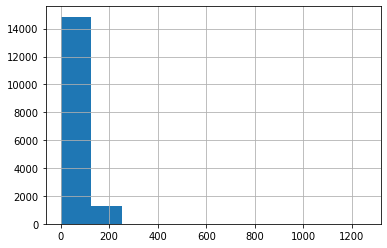

In [29]:
movies_df_pd['Runtime'].hist()

A distribuição de runtime dos filmes ficou ruim de ser visualizada no histograma possivelmente por causa de outliers. Iremos utiliza o log10 para visualizar melhor.

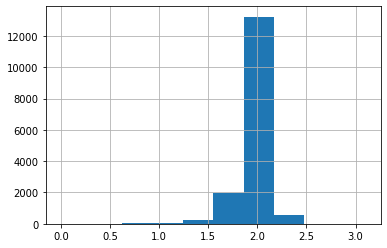

In [30]:
from numpy import log10
movies_df_pd['runtime_log'] = log10(movies_df_pd['Runtime'])
movies_df_pd['runtime_log'].hist()

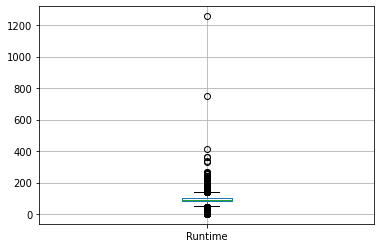

In [31]:
movies_df_pd.boxplot(column='Runtime')

Analisando o boxplot, fica claro que existem outliers. Vamos Fazer o processo de remoção utilizando o Z-Score Robusto (MAD). 

In [32]:
from numpy import abs
mad = abs(movies_df_pd['runtime_log'] - movies_df_pd['runtime_log'].median()).median()*(1/0.6745)
print(mad)

0.07409040023993868


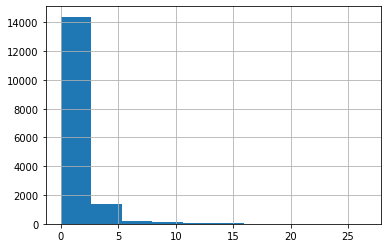

In [33]:
(abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad).hist()

Analisamos os dados que iriam sair (outliers) e os que iriam ficar e notamos que ainda existiam muitos filmes outliers iriam continuar no dataset, por isso escolhemos um valor de MAD maior.

In [34]:
movies_df_mad = movies_df_pd[abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad < 6]
movies_df_mad

,ID,Title,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,DirectorsArray,GenresArray,CountriesArray,LanguagesArray,MinimumClassification,RottenTomatoes,runtime_log
0,1,Inception,2010,8.8,1,0,0,0,148.0,[Christopher Nolan],"[Action, Adventure, Sci-Fi, Thriller]","[United States, United Kingdom]","[English, Japanese, French]",13,8.7,2.170262
1,2,The Matrix,1999,8.7,1,0,0,0,136.0,"[Lana Wachowski, Lilly Wachowski]","[Action, Sci-Fi]",[United States],[English],18,8.7,2.133539
2,3,Avengers: Infinity War,2018,8.5,1,0,0,0,149.0,"[Anthony Russo, Joe Russo]","[Action, Adventure, Sci-Fi]",[United States],[English],13,8.4,2.173186
3,4,Back to the Future,1985,8.5,1,0,0,0,116.0,[Robert Zemeckis],"[Adventure, Comedy, Sci-Fi]",[United States],[English],7,9.6,2.064458
4,5,"The Good, the Bad and the Ugly",1966,8.8,1,0,1,0,161.0,[Sergio Leone],[Western],"[Italy, Spain, West Germany]",[Italian],18,9.7,2.206826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16733,16735,Sultan And The Rock Star,1980,5.9,0,0,0,1,60.0,[Edward M. Abroms],"[Adventure, Drama, Family]",[United States],[English],-1,NaN,1.778151
16736,16738,The Bears and I,1974,6.2,0,0,0,1,89.0,[Bernard McEveety],"[Drama, Family]",[United States],[English],0,NaN,1.949390
16737,16739,Whispers: An Elephant's Tale,2000,5.0,0,0,0,1,72.0,[Dereck Joubert],"[Adventure, Family]",[United States],[English],0,NaN,1.857332
16738,16740,The Ghosts of Buxley Hall,1980,6.2,0,0,0,1,120.0,[Bruce Bilson],"[Comedy, Family, Fantasy, Horror]",[United States],[English],-1,NaN,2.079181


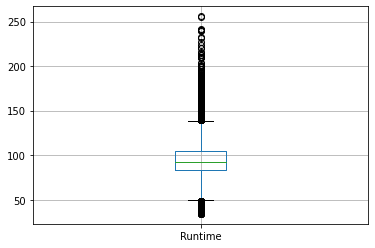

In [35]:
movies_df_mad.boxplot(column='Runtime')

In [36]:
movies_no_outliers = movies_df_mad

#### Bivariado

Vamos detectar outliers agora a partir das colunas de notas, IMDb e Rotten Tomatoes.

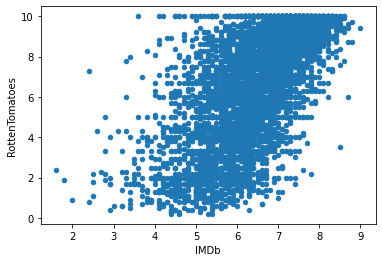

In [37]:
movies_no_outliers.plot.scatter(x='IMDb', y='RottenTomatoes')

In [38]:
movies_no_outliers['rating_rate'] = movies_no_outliers['RottenTomatoes'] / movies_no_outliers['IMDb']
movies_no_outliers['rating_rate'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count    5070.000000
mean        1.008390
std         0.373930
min         0.037037
25%         0.757576
50%         1.094595
75%         1.272727
max         3.041667
Name: rating_rate, dtype: float64

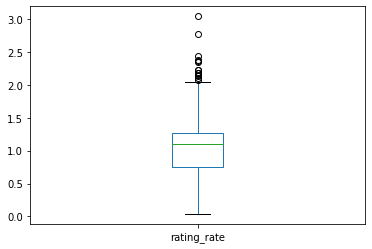

In [39]:
movies_no_outliers['rating_rate'].plot.box()

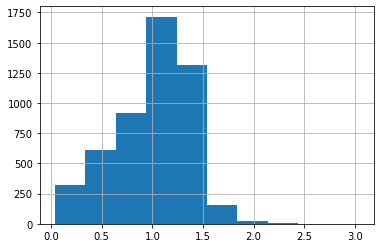

In [40]:
movies_no_outliers['rating_rate'].hist()

In [41]:
mad = abs(movies_no_outliers['rating_rate'] - movies_no_outliers['rating_rate'].median()).median()*(1/0.6745)
print(mad)

0.3405926311782501


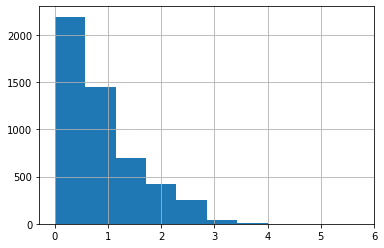

In [42]:
(abs(movies_no_outliers['rating_rate']-movies_no_outliers['rating_rate'].median())/mad).hist()

In [43]:
movies_no_outliers[abs(movies_no_outliers['rating_rate']-movies_no_outliers['rating_rate'].median())/mad >= 3][['IMDb', 'RottenTomatoes', 'rating_rate']]

,IMDb,RottenTomatoes,rating_rate
1368,4.7,10.0,2.127660
2043,4.4,0.3,0.068182
4208,4.4,0.2,0.045455
4257,5.4,0.2,0.037037
5342,4.6,10.0,2.173913
5466,4.1,8.8,2.146341
5563,4.5,10.0,2.222222
5888,4.2,10.0,2.380952
6041,4.6,10.0,2.173913
6158,4.1,10.0,2.439024


In [44]:
movies_df_mad_bi = movies_no_outliers[abs(movies_no_outliers['rating_rate']-movies_no_outliers['rating_rate'].median())/mad < 3]

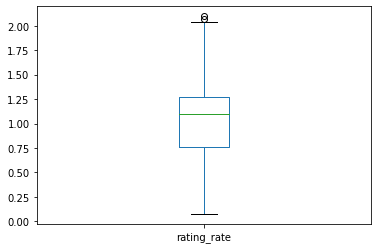

In [45]:
movies_df_mad_bi['rating_rate'].plot.box()

In [46]:
movies_no_outliers = movies_df_mad_bi

Vamos transformar o dataframe de Pandas em Pyspark para utilizar futuramente, a fim de fazer queries, etc.

In [47]:
movies_no_outliers_py = sql_context.createDataFrame(movies_no_outliers)
movies_no_outliers_py.show(5)

+---+--------------------+----+----+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------+------------------+------------------+
| ID|               Title|Year|IMDb|Netflix|Hulu|Prime Video|Disney+|Runtime|      DirectorsArray|         GenresArray|      CountriesArray|      LanguagesArray|MinimumClassification|RottenTomatoes|       runtime_log|       rating_rate|
+---+--------------------+----+----+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------+------------------+------------------+
|  1|           Inception|2010| 8.8|      1|   0|          0|      0|  148.0| [Christopher Nolan]|[Action, Adventur...|[United States, U...|[English, Japanes...|                   13|           8.7|2.1702617153949575|0.9886363636363634|
|  2|          The Matrix|1999| 8.7|      1|   0|   

Como removemos vários outliers, vamos atualizar as tabelas que explodimos anteriormente, para ter as informacoes dos arrays separadamente.

In [48]:
movie_director_df = movies_no_outliers_py.select('ID', 'DirectorsArray').withColumn('Director', explode(col('DirectorsArray'))).select('ID', 'Director')
movie_genre_df = movies_no_outliers_py.select('ID', 'GenresArray').withColumn('Genre', explode(col('GenresArray'))).select('ID', 'Genre')
movie_country_df = movies_no_outliers_py.select('ID', 'CountriesArray').withColumn('Country', explode(col('CountriesArray'))).select('ID', 'Country')
movie_language_df = movies_no_outliers_py.select('ID', 'LanguagesArray').withColumn('Language', explode(col('LanguagesArray'))).select('ID', 'Language')

### Análises Descritivas

Iremos rodar a correlação de spearman sobre o dataset para verificar se há algum tipo de correlação entre as colunas.

Podemos perceber que há uma correlação alta e positiva entre as colunas RottenTomatoes e IMDb, que é esperado porque ambos representam a opinião sobre o filme.

In [49]:
movies_no_outliers.corr(method='spearman')

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,runtime_log,rating_rate
ID,1.000000,-0.332790,-0.290336,-0.776263,-0.217045,0.539221,0.398049,-0.198961,-0.141576,-0.280370,-0.198961,-0.194900
Year,-0.332790,1.000000,-0.119711,0.322111,0.152627,-0.280248,-0.186697,0.022597,-0.037418,0.076419,0.022597,0.156005
IMDb,-0.290336,-0.119711,1.000000,0.032672,-0.013310,-0.049930,0.036764,0.205563,-0.098058,0.630890,0.205563,0.288594
Netflix,-0.776263,0.322111,0.032672,1.000000,-0.212864,-0.644810,-0.153063,0.107200,0.097192,0.020211,0.107200,-0.004528
Hulu,-0.217045,0.152627,-0.013310,-0.212864,1.000000,-0.244559,-0.086595,0.019192,0.047335,0.020343,0.019192,0.033851
Prime Video,0.539221,-0.280248,-0.049930,-0.644810,-0.244559,1.000000,-0.309820,-0.063600,-0.039630,-0.047219,-0.063600,-0.022291
Disney+,0.398049,-0.186697,0.036764,-0.153063,-0.086595,-0.309820,1.000000,-0.028815,-0.073778,-0.015980,-0.028815,-0.045844
Runtime,-0.198961,0.022597,0.205563,0.107200,0.019192,-0.063600,-0.028815,1.000000,0.162155,-0.007897,1.000000,-0.105624
MinimumClassification,-0.141576,-0.037418,-0.098058,0.097192,0.047335,-0.039630,-0.073778,0.162155,1.000000,-0.210626,0.162155,-0.214077
RottenTomatoes,-0.280370,0.076419,0.630890,0.020211,0.020343,-0.047219,-0.015980,-0.007897,-0.210626,1.000000,-0.007897,0.897601


#### Análise Plataformas de streaming

Agora ao analisar a quantidade de filmes por plataforma de streaming, percebemos que a maior parte dos dados é composta por filmes que estão no Prime Video.

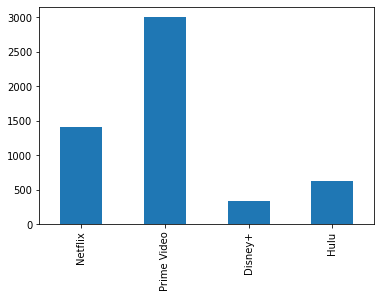

In [50]:
movies_no_outliers[['Netflix', 'Prime Video', 'Disney+', 'Hulu']].sum(skipna=True).plot.bar()

#### Análise de número de filmes por década e ano

Agora vamos analisar a criação de filmes ao longo das décadas.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


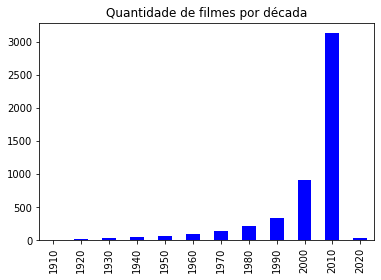

In [51]:
movies_no_outliers['decade'] = movies_no_outliers['Year'].floordiv(10) * 10
quantity_movies_by_decade = movies_no_outliers['decade'].value_counts().sort_index()
quantity_movies_by_decade.plot.bar(color=(0,0,1), title='Quantidade de filmes por década')

Percebemos que a produção de filmes segue uma função exponencial.

Vamos analisar a década de 2010, que é o que possui mais filmes.

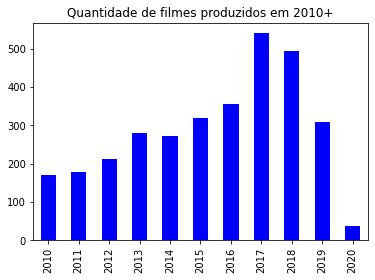

In [52]:
movies_df_2010 = movies_no_outliers[movies_no_outliers['Year'] >= 2010]
movies_df_2010 = movies_df_2010.sort_values(['Year'])
quantity_movies_2010 = movies_df_2010['Year'].value_counts().sort_index()
quantity_movies_2010.plot.bar(color=(0,0,1), title='Quantidade de filmes produzidos em 2010+')

Houve uma queda de quantidade de filmes feitos em 2018 e 2019, porém não sabemos o motivo (procuramos na internet, porém não achamos nada) ou se foi falta de dados no dataset.

#### Análise de notas (IMBd e Rotten Tomatoes)

Vamos analisar a média de notas durante a década de 2010.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


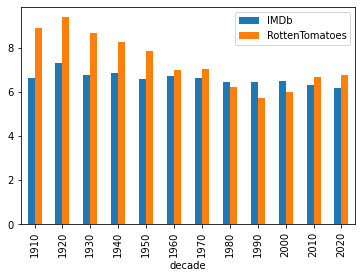

In [53]:
movies_plataform_rate_mean = movies_no_outliers.groupby('decade')['IMDb', 'RottenTomatoes'].mean()
movies_plataform_rate_mean.sort_index().plot.bar()

Analisando o grafico acima, comparado ao Rotten Tomatoes, o IMDb parece ser mais crítico em relação as notas.

In [54]:
from pyspark.sql.functions import when,count,countDistinct

movies_df_aval = movies_no_outliers_py.where(col('IMDb').isNotNull() & col('RottenTomatoes').isNotNull())

movies_df_aval.agg(
    count(when(col("IMDb") >= 9, True)).alias('IMDb Count'),
    count(when(col("RottenTomatoes") >= 9, True)).alias('RottenTomatoes Count')
).show()

+----------+--------------------+
|IMDb Count|RottenTomatoes Count|
+----------+--------------------+
|         1|                1097|
+----------+--------------------+



#### Análise linguagem

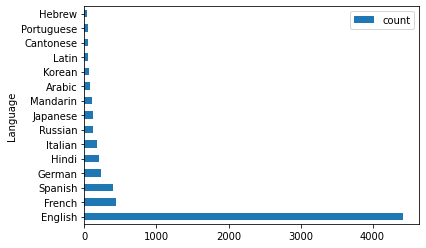

In [55]:
movies_count_by_language = movie_language_df.groupBy('Language').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_language.nlargest(15, 'count').plot.barh(x='Language')

Podemos perceber que a linguagem predominante é inglês, o que é esperado.

#### Análise gênero

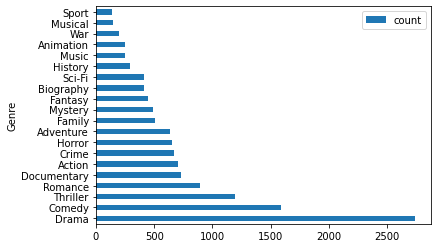

In [56]:
movies_count_by_genre = movie_genre_df.groupBy('Genre').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_genre.nlargest(20, 'count').plot.barh(x='Genre')

Drama é o gênero que possui a maior quantidade de filmes.

#### Análise país

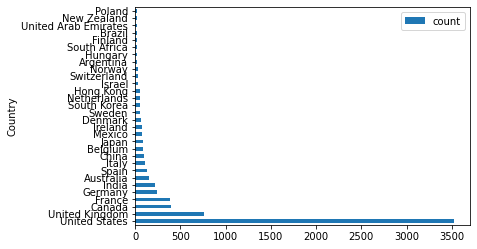

In [57]:
movies_count_by_country = movie_country_df.groupBy('Country').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_country.nlargest(30, 'count').plot.barh(x='Country')

Estatos Unidos é o maior produtor de filmes, o que explica a grande quantidade de filmes em inglês. 

#### Análise Diretores





Inicialmente, vamos ver os top 20 diretores que fizeram mais filmes

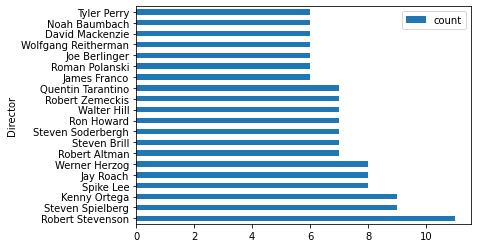

In [58]:
movies_count_by_directors = movie_director_df.groupBy('Director').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_directors.nlargest(20, 'count').plot.barh(x='Director')

In [59]:
from pyspark.sql.functions import mean

directors_stats_pyspark = movie_director_df.distinct()\
                            .join(movies_no_outliers_py, movies_no_outliers_py['ID'] == movie_director_df['ID'])\
                            .select('Director', 'IMDb', 'RottenTomatoes', movie_director_df['ID'])\
                            .groupBy('Director')\
                            .agg(count('ID').alias('movies_count'), mean('IMDb').alias('IMDb_mean'), mean('RottenTomatoes').alias('RottenTomatoes_mean'))\
                            
directors_stats = directors_stats_pyspark.toPandas()
directors_stats

,Director,movies_count,IMDb_mean,RottenTomatoes_mean
0,Perry Moore,1,5.9,1.2
1,John Wells,1,6.7,6.7
2,April Mullen,1,5.5,2.2
3,Jim Jarmusch,2,7.3,9.5
4,Dino Athanassiou,1,4.5,0.4
...,...,...,...,...
4285,Jay Alaimo,1,6.7,7.0
4286,Fab 5 Freddy,1,7.2,10.0
4287,Bernardo Ruiz,1,6.7,7.9
4288,Xavier Manrique,1,5.1,4.0


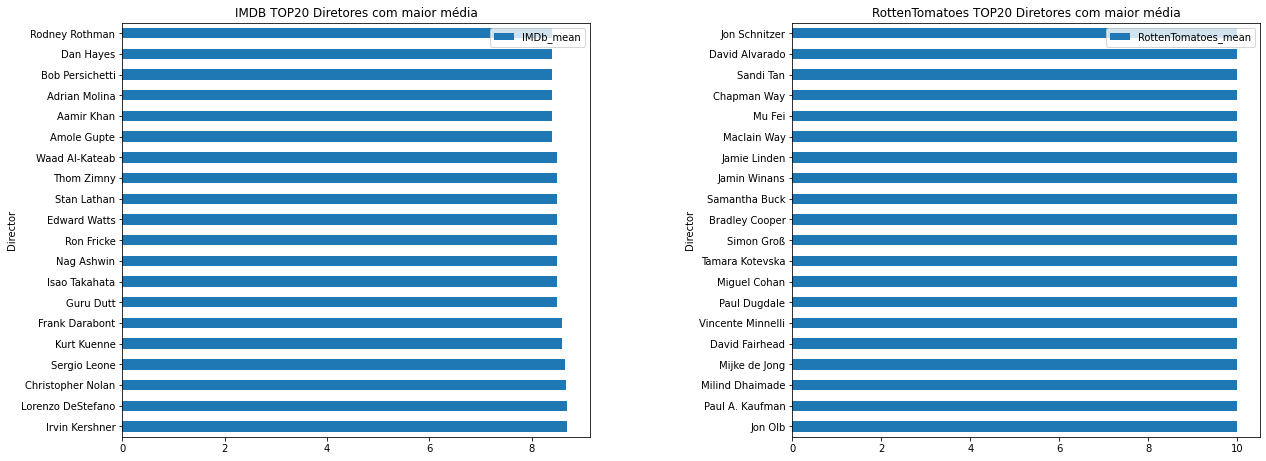

In [60]:
import matplotlib.pyplot as plt

sorted_imdb = directors_stats.sort_values(by='IMDb_mean', ascending=False).head(20) 
sorted_rotten = directors_stats.sort_values(by='RottenTomatoes_mean', ascending=False).head(20) 

fig, axes = plt.subplots(1, 2)
fig.tight_layout(pad=3.0)
sorted_imdb[['Director', 'IMDb_mean']].plot.barh(x='Director', ax=axes[0], figsize=(20, 8), title='IMDB TOP20 Diretores com maior média')
sorted_rotten[['Director', 'RottenTomatoes_mean']].plot.barh(x='Director', ax=axes[1], figsize=(20, 8), title='RottenTomatoes TOP20 Diretores com maior média')

Esses diretores estão com uma média muito alta, principalmente os do Rotten Tomatoes, no qual todos os Top 20 possuem média 10. Analisando Irvin Kershner, por exemplo, podemos notar que só existe uma nota relacionada a ele

In [61]:
movie_director_df.distinct()\
.join(movies_no_outliers_py, movies_no_outliers_py['ID'] == movie_director_df['ID'])\
.select('Director', 'IMDb').where(col('Director') == 'Irvin Kershner').show()

+--------------+----+
|      Director|IMDb|
+--------------+----+
|Irvin Kershner| 8.7|
+--------------+----+



Vamos ver a quantidade de diretores por filmes feitos:

In [62]:
directors_movie_count = movie_director_df.distinct()\
                            .groupBy('Director')\
                            .agg(count('ID').alias('Total Movies'))\
                            .groupBy('Total Movies').agg(count('Director').alias('Total Director')).orderBy(col('Total Movies')).toPandas()
directors_movie_count

,Total Movies,Total Director
0,1,3384
1,2,599
2,3,179
3,4,67
4,5,34
5,6,14
6,7,7
7,8,3
8,9,2
9,11,1


Com isso iremos pegar a média de filmes feitos por diretor e fazer nossas analises baseado nos diretores que fizeram pelo menos a media de filmes.

In [63]:
directors_movies_mean = movie_director_df.distinct()\
                            .groupBy('Director')\
                            .agg(count('ID').alias('Total Movies'))\
                            .select(mean('Total Movies').alias('mean'))\
                            .collect()[0][0]
directors_movies_mean

1.3386946386946388

Vamos agora analisar quais diretores produziram mais filmes.

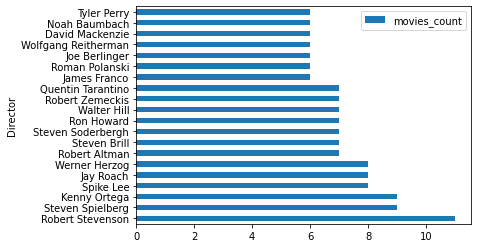

In [64]:
directors_filtered = directors_stats_pyspark.distinct()\
                            .where(col('movies_count') >= directors_movies_mean)\
                            .toPandas()
directors_filtered.nlargest(20, 'movies_count')[['Director', 'movies_count']].plot.barh(x='Director')

Vamos analisar o diretor que possui maior média.

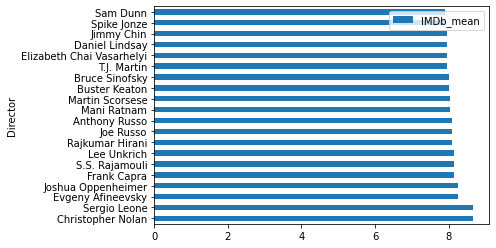

In [65]:
directors_high_grade_count = directors_stats_pyspark.distinct()\
                            .where(col('movies_count') >= directors_movies_mean).toPandas()
directors_high_grade_count.nlargest(20, 'IMDb_mean')[['Director', 'IMDb_mean']].plot.barh(x='Director')

### Hipóteses

HIPOTESES
1. Notas dos filmes seguem uma distribuição normal
2. IMDb é mais rígido em relação a notas do que o Rotten Tomatoes
3. Filmes de terror e ação tem uma classificacao indicativa maior
4. Filmes de drama tem maiores notas
5. Filmes na Plataforma da Netflix possuem notas mais altas

In [66]:
from scipy import stats

#### Hipótese 1

Acreditamos que as notas dos filmes seguem uma distribuição normal, pelo fato de que as pessoas geralmente tendem a não avaliar muitos filmes com nota máxima nem mínima, mas sim com notas medianas, fazendo com que notas medianas tenham uma maior quantidade do que notas muito boas ou notas muito ruins.

In [67]:
# vamos dropar os nan porque não nos interessa nos cálculos
movies_processed_pd = movies_no_outliers.dropna()

Vamos checar agora se as notas do imdb e rotten tomatoes seguem uma distribuição normal

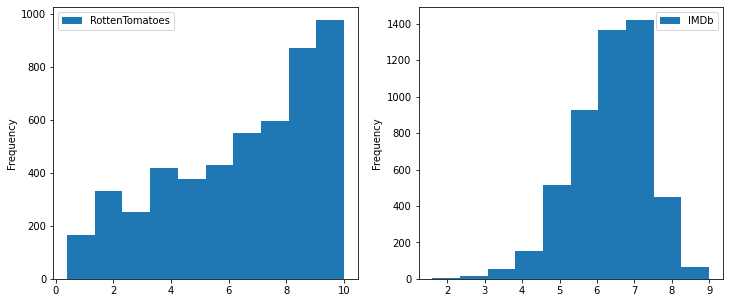

In [68]:
fig, axes = plt.subplots(1, 2)

movies_processed_pd[['RottenTomatoes']].plot(kind='hist', ax=axes[0], figsize=(12, 5))
movies_processed_pd[['IMDb']].plot(kind='hist', ax=axes[1], figsize=(12, 5))

In [69]:
stat_rotten, p_rotten = stats.shapiro(movies_processed_pd['RottenTomatoes'])
stat_imdb, p_imdb = stats.shapiro(movies_processed_pd['IMDb'])

print("p-value rotten tomatoes ", p_rotten)
print("p-value imdb ", p_imdb)

p-value rotten tomatoes  4.3860641933366774e-43
p-value imdb  7.0553333058729e-25


Utilizando a função shapiro percebemos que o p value deu muito baixo rejeitando assim a hipótese nula de que as distribuições são normais. Desse modo, rejeitamos nossa hipótese 1.

#### Hipótese 2

Acreditamos que o IMDb é mais crítico em relação a notas do que o Rotten Tomatoes. Acreditamos nisso porque ao olhar os dados na etapa de análise percebemos algumas notas do Rotten tomatoes maiores que as do IMDb. 

Vamos utilizar a função do Wilcoxon para realizar esse teste. Colocaremos a hipótese nula como a distribuição das notas do Rotten tomatoes serem maiores que a dos IMDb, e assim utilizaremos o parametro alternative para configurar a hipotese alternativa como sendo menor.\
H0 - RottenTomatoes > IMDb\
HA - RottenTomatoes < IMDb (alternative = 'less')

In [70]:
stats.wilcoxon(movies_processed_pd['RottenTomatoes'], movies_processed_pd['IMDb'], alternative='less')

WilcoxonResult(statistic=6680944.0, pvalue=0.9999999999899049)

Como o p-value foi muito alto provamos a hipótese nula de que a distribuição de notas no Rotten Tomatoes são maiores do que a do IMDb, logo o IMDb é mais rígido em relação a notas.

#### Hipótese 3

Vamos agora verificar as idades classificativas de acordo com os gêneros dos filmes, queremos mostrar que filmes de terror e ação são mais propensos a ter classificações mais altas.

In [71]:
# primeiro vamos cruzar os dados de gênero com os de filme
movies_genre_by_minimum_class = movie_genre_df.join(movies_no_outliers_py, movies_no_outliers_py['ID'] == movie_genre_df['ID'])\
                                              .select('Genre', 'MinimumClassification')\
                                              .where(col('MinimumClassification') >= 0)
movies_genre_by_minimum_class_pd = movies_genre_by_minimum_class.toPandas()
movies_genre_by_minimum_class_pd

,Genre,MinimumClassification
0,Drama,18
1,Mystery,18
2,Sci-Fi,18
3,Thriller,18
4,Biography,18
...,...,...
9490,Fantasy,0
9491,Action,13
9492,Drama,13
9493,History,13


In [72]:
genres = movies_genre_by_minimum_class_pd.Genre.unique()

In [73]:
movies_genre_by_minimum_class_pd.dtypes

Genre                    object
MinimumClassification     int64
dtype: object

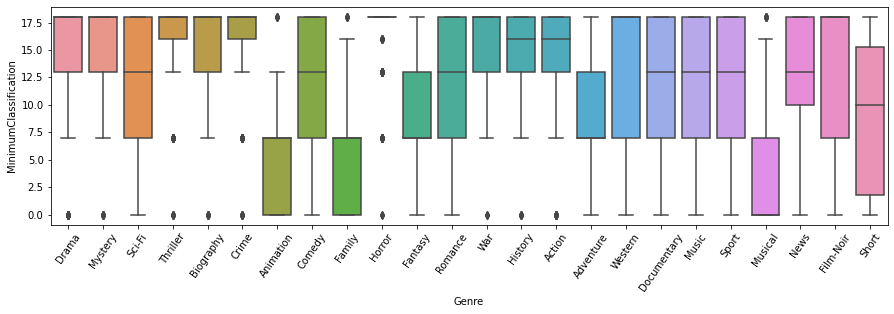

In [74]:
import seaborn as sns
fig, axes = plt.subplots(figsize=(15, 4))
for tick in axes.get_xticklabels():
    tick.set_rotation(55)
sns.boxplot(x='Genre', y='MinimumClassification', data=movies_genre_by_minimum_class_pd, ax=axes)

Como podemos ver através do gráfico acima, genêros como: Ação (Action), Suspense (Thriller), Guerra (War), Crime (Crime), Mistério (Mystery) e Terror (Horror), são genêros que possuem uma variação de classificação bem alta, com foco em Ação, Gerra, Crime que tem o primeiro quartil em 13 anos e o terceiro em 18, com a mediana em 18 anos nos casos de Ação e Crime. Destaca-se o gênero de terror que possui o primeiro quartil em 16 anos e com mediana e terceiro quartil em 18 anos. Os dados mostraram o que já era esperado.

#### Hipótese 4

Como drama é o gênero de filme que [possui mais Oscars](https://www.bbc.com/portuguese/curiosidades-51390633#:~:text=Drama%20%C3%A9%20o%20g%C3%AAnero%20mais,distribu%C3%ADdas%20entre%20diversos%20g%C3%AAneros%20diferentes), supomos que as suas notas são as maiores.

In [75]:
movies_without_missing_rating = movies_no_outliers_py.where(col('IMDb').isNotNull() & col('RottenTomatoes').isNotNull())\
                                                   .join(movie_genre_df, movies_no_outliers_py['ID'] == movie_genre_df['ID'])\
                                                   .select(movies_no_outliers_py['ID'], col('Genre'), col('IMDb'), col('RottenTomatoes'))
movies_without_missing_rating_pd = movies_without_missing_rating.toPandas()

In [76]:
# vamos remover os outliers (gêneros que possuem poucos filmes)
genres_count = movies_without_missing_rating.groupBy('Genre').agg(count('ID').alias('total')).select('Genre', 'total')
non_outliers_genres = genres_count.where(col('total') >= genres_count.approxQuantile('total',[0.25], 0)[0]).select('Genre').rdd.map(lambda row : row[0]).collect()

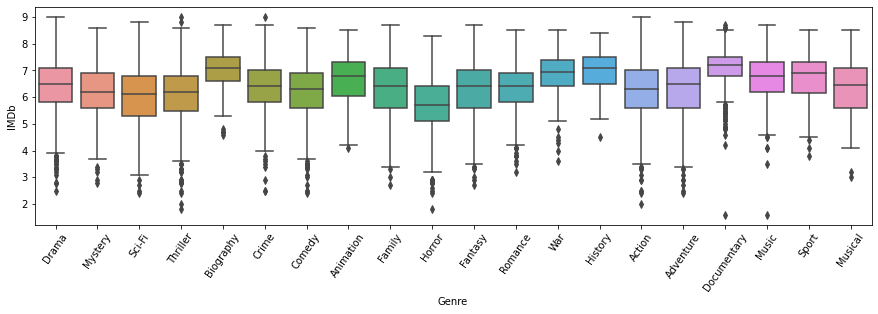

In [77]:
non_outliers_genre_movies = movies_without_missing_rating_pd[movies_without_missing_rating_pd['Genre'].isin(non_outliers_genres)]
fig, axes = plt.subplots(figsize=(15, 4))
for tick in axes.get_xticklabels():
    tick.set_rotation(55)
sns.boxplot(x='Genre', y='IMDb', data=non_outliers_genre_movies, ax=axes)

Para provarmos que `drama` não é o gênero com melhores notas, vamos comparar sua distribuição com `documentary`, pois é a que parece ter as melhores notas, analisando o box plot. Logo vamos definir as hipóteses:

H0 - Drama > Documentary\
HA - Drama < Documentary (alternative = 'less')

In [78]:
documentary_genre = non_outliers_genre_movies[non_outliers_genre_movies['Genre'] == 'Documentary']
drama_genre = non_outliers_genre_movies[non_outliers_genre_movies['Genre'] == 'Drama']
stats.mannwhitneyu(drama_genre['IMDb'], documentary_genre['IMDb'], alternative='less')

MannwhitneyuResult(statistic=540041.5, pvalue=1.8686355017804276e-81)

In [79]:
documentary_genre = non_outliers_genre_movies[non_outliers_genre_movies['Genre'] == 'Documentary']
drama_genre = non_outliers_genre_movies[non_outliers_genre_movies['Genre'] == 'Drama']
stats.mannwhitneyu(drama_genre['RottenTomatoes'], documentary_genre['RottenTomatoes'], alternative='less')

MannwhitneyuResult(statistic=568227.0, pvalue=5.543028229005309e-72)

Como para as duas plataformas de avaliação o p-value deu muito baixo, a hipótese nula foi refutada. Portanto drama não é o gênero mais bem avaliado

#### Hipótese 5

Por ser a plataforma de streaming mais popular, supomos que as notas dos filmes da `Netflix` são maiores que as outras plataformas.

Text(0.5, 1.0, 'Rotten Tomatoes')

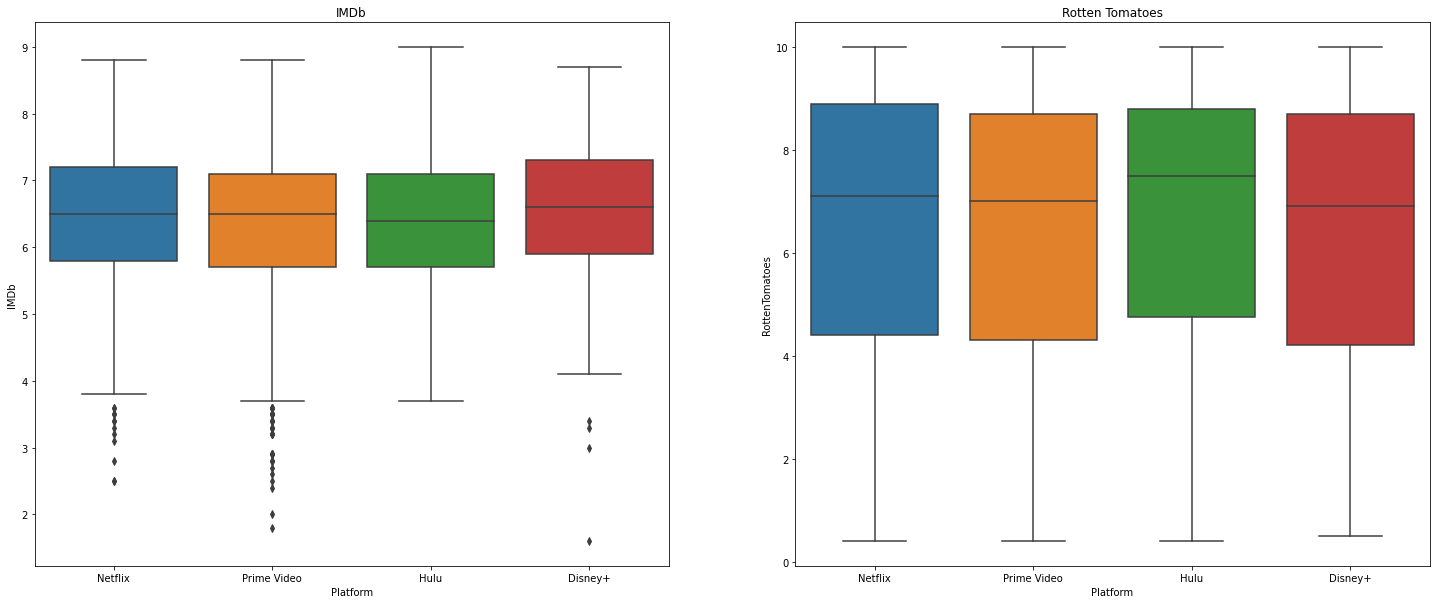

In [80]:
# Vamos utilizar a função melt para transformar em valores de uma coluna (Platform) as colunas das plataformas, para todos os casos que a plataforma tenha o filme 
plataform_rating = movies_no_outliers.melt(id_vars=['IMDb', 'RottenTomatoes'], value_vars=['Netflix', 'Prime Video', 'Hulu', 'Disney+'], var_name='Platform', value_name='Has')
plataform_rating = plataform_rating[plataform_rating['Has'] == 1]
fig, axes = plt.subplots(1,2, figsize=(25, 10))
sns.boxplot(x='Platform', y='IMDb', data=plataform_rating, ax=axes[0]).set_title('IMDb')
sns.boxplot(x='Platform', y='RottenTomatoes', data=plataform_rating, ax=axes[1]).set_title('Rotten Tomatoes')

Analisando os boxes plots pode-se perceber que no caso do `IMDB`, `Netflix` e `Disney+` são os mais bem avaliados. Já para o caso do `Rotten Tomatoes`, são `Netflix`e `Hulu`. Vamos fazer um teste de hipótese para estes dois casos.

Vamos utilizar a função do Mannwhitneyu para realizar esse teste. Colocaremos a hipótese nula como a distribuição das notas do IMDb da Netflix serem maiores que a dos IMDb da Disney+.

H0 - IMDb - Netflix > IMDb - Disney+\
HA - IMDb - Netflix < IMDb - Disney+ (alternative = 'less')

In [81]:
netflix_rating = plataform_rating[plataform_rating['Platform'] == 'Netflix']
disney_rating = plataform_rating[plataform_rating['Platform'] == 'Disney+']
stats.mannwhitneyu(netflix_rating['IMDb'], disney_rating['IMDb'], alternative='less')

MannwhitneyuResult(statistic=228203.0, pvalue=0.08698543336883019)

Como o p-value está próximo do intervalo de confiança, vamos ver se suas notas são parecidos.

H0 - IMDb - Netflix == IMDb - Disney+\
HA - IMDb - Netflix != IMDb - Disney+ (alternative = 'two-sided')

In [82]:
stats.mannwhitneyu(netflix_rating['IMDb'], disney_rating['IMDb'], alternative='two-sided')

MannwhitneyuResult(statistic=228203.0, pvalue=0.17397086673766038)

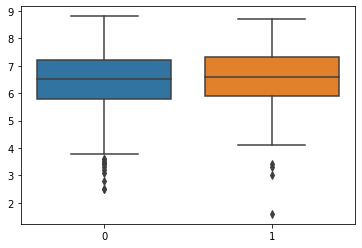

In [83]:
sns.boxplot(data=[netflix_rating['IMDb'], disney_rating['IMDb']])

Pelo segundo teste de hipósese (two-sided) foi provado que existe uma maior evidência que Netflix e Disney+ possuem notas semelhantes do que Netflix ser maior (primeiro teste de hipotese), logo podemos dizer que Netflix é uma das melhores plataformas pelo IMDb.

Agora iremos fazer o mesmo teste entre `Rotten Tomatoes - Neflix` e `Rotten Tomatoes - Hulu`

H0 - Rotten Tomatoes - Netflix > Rotten Tomatoes - Hulu\
HA - Rotten Tomatoes - Netflix < Rotten Tomatoes - Hulu (alternative = 'less')

In [84]:
hulu_rating = plataform_rating[plataform_rating['Platform'] == 'Hulu']
stats.mannwhitneyu(netflix_rating['RottenTomatoes'], hulu_rating['RottenTomatoes'], alternative='less')

MannwhitneyuResult(statistic=433040.5, pvalue=0.35212913725358935)

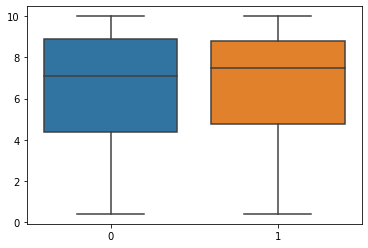

In [85]:
sns.boxplot(data=[netflix_rating['RottenTomatoes'], hulu_rating['RottenTomatoes']])

Como o p-value foi alto provamos a hipótese nula de que a distribuição de notas da Netflix no Rotten Tomatoes são maiores do que a do Hulu no Rotten Tomatoes.